# Hidden Markov Model

This notebook demonstrates the process of training Categorical Hidden Markov Models (HMMs) for sentiment classification using the Twitter and Reddit Dataset (adapted for text-based analysis). The main steps include:

- Building a shared vocabulary and encoding sequences
- Training three separate HMMs for positive, negative, and neutral sentiments
- Predicting sentiment of unseen sequences using log-likelihood scoring
- Evaluating classification performance using confusion matrices and precision/recall metrics

Our goal is to effectively model sequential patterns in tokenized text and improve sentiment classification by leveraging the temporal structure captured by HMMs.

In [87]:
# General libraries
import pandas as pd
import os
import numpy as np

# Libraries for processing the data
import re
from collections import Counter

# Library for model
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from hmmlearn.hmm import CategoricalHMM

# Library for drawing 
import matplotlib.pyplot as plt

### 1. Prepare Data

In this section, we prepare the data by:
- Grouping the dataset from Twitter and Reddit
- Splitting this big dataset into training and testing sets

In [2]:
# Read raw data and drop the missing values
df_twitter = pd.read_csv('../../data/raw/dataset_phase_2/Twitter_Data.csv')
df_twitter = df_twitter.loc[:, ~df_twitter.columns.str.contains('Unnamed: 0')]
df_twitter = df_twitter.rename(columns={"clean_text": "text"})
df_twitter.dropna(subset=["text", "category"], inplace=True)

df_reddit = pd.read_csv('../../data/raw/dataset_phase_2/Reddit_Data.csv')
df_reddit = df_reddit.loc[:, ~df_reddit.columns.str.contains('Unnamed: 0')]
df_reddit = df_reddit.rename(columns={"clean_comment": "text"})
df_reddit.dropna(subset=["text", "category"], inplace=True)

# Combine into a dataset for both sources
df = pd.concat([df_twitter, df_reddit], ignore_index=True)
df

,text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0
...,...,...
200113,jesus,0.0
200114,kya bhai pure saal chutiya banaya modi aur jab...,1.0
200115,downvote karna tha par upvote hogaya,0.0
200116,haha nice,1.0


In [3]:
# Split the dataset into training set and test set
def split_dataset(df):
    return train_test_split(
        df, 
        test_size = 0.2,          
        stratify = df["category"],  
        random_state = 42         
    )

df_train, df_test = split_dataset(df)
df_train, df_test

(                                                     text  category
 57976   making fun achievements country politics lies ...       1.0
 132223  modi spends crores facials ignores the faceles...       0.0
 41826   wants grow your business india start contact 9...       1.0
 18622   choice this pic best the reaction modi hearing...       1.0
 161135  bjp will better than 2014 along with other par...       1.0
 ...                                                   ...       ...
 175604  they are hellbent the left good right bad narr...       1.0
 58355   fantastic leadership modi jai maa bharti\nindi...       1.0
 145456  sir this info good for academic interest but d...       1.0
 93922   can recollect those sweet memory 2014 campaign...       1.0
 744         modi has merely renamed out congress schemes       -1.0
 
 [160094 rows x 2 columns],
                                                      text  category
 51562   congratulate rahul gandhi for helping modi bec...       1.0
 161

### 2. Build Features

In this step, we preprocess the text data by performing the following:
- **Class-wise Splitting**: The training dataset is divided into three sentiment categories: **Positive**, **Negative**, **Neutral**.
- **Tokenization**: Each sentence is tokenized into a sequence of word tokens using a consistent tokenizer.

This ensures that the data is cleanly organized and prepared for building a shared vocabulary and encoding in the next step.

In [4]:
# Group training sentences by sentiment label
def separate_sentiment(df):
    return df[df["category"] == 1]["text"].tolist(), df[df["category"] == -1]["text"].tolist(), df[df["category"] == 0]["text"].tolist()

train_pos, train_neg, train_neu = separate_sentiment(df_train)
train_pos[:3], train_neg[:3], train_neu[:3]

(['making fun achievements country politics lies issues fakery befriending pakistan but not word praise for our own prime minister this rahul gandhi and they not see politics beyond hatred for modi and ardent believers modi',
  'wants grow your business india start contact 9971696487',
  'choice this pic best the reaction modi hearing this news'],
 ['modi has brought bill citizenship pakistani hindusand even the lower house the parliament has passed but the upper house has not passed yet due lack majority modicongress party not supporting this bill ',
  'throw those cups desperate modi',
  'unfortunate couldnt find space mention about drdo word appreciation who are the actual ones appreciateddilution institutions autonomous bodies core policy always overhyped chest thumping from modi projecting designed '],
 ['modi spends crores facials ignores the faceless kanhaiya kumar elections news ',
  'have two options this elections choose from\n… lotus\n… lootus agar majburi naam mahatma gandh

In [5]:
# Preprocessing: Tokenize a text into list of lowercase alphabetical characters
def tokenize_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    return text.split()

# Apply tokenization for list of text
def tokenize_list_text(lst):
    return [tokenize_text(text) for text in lst]

processed_train_pos = tokenize_list_text(train_pos)
processed_train_neg = tokenize_list_text(train_neg)
processed_train_neu = tokenize_list_text(train_neu)
processed_train_pos[0][:5], processed_train_neg[0][:5], processed_train_neu[0][:5]

(['making', 'fun', 'achievements', 'country', 'politics'],
 ['modi', 'has', 'brought', 'bill', 'citizenship'],
 ['modi', 'spends', 'crores', 'facials', 'ignores'])

### 3. Model training

In this section, we train three separate Categorical Hidden Markov Models (HMMs) for sentiment classification — one for each class: Positive, Negative, and Neutral.

The steps involved are:
- **Building a Shared Vocabulary**: A single vocabulary is constructed from all tokenized training data across the three classes. This shared vocabulary ensures that each model interprets tokens consistently. An `<UNK>` token is added to handle out-of-vocabulary words during prediction.
- **Encoding Token Sequences**: Tokenized sentences are converted to sequences of integer values based on the shared vocabulary. These encoded sequences are used as inputs for the HMMs.
- **Training the HMMs**: Each class-specific HMM is trained using its respective set of encoded sequences. The training uses the CategoricalHMM from hmmlearn, which models sequences of discrete symbols. Key hyperparameters include:
  - `n_components`: number of hidden states.
  - `n_iter`: number of training iterations.
  - `tol`: convergence threshold for log-likelihood improvement.
    
  The sequences are concatenated into a single array per class, and the corresponding lengths are provided to allow the model to learn from multiple sequences.

After training, each model is specialized to generate sequences resembling the sentiment it represents. These trained models will later be used for prediction of test dataset.

In [42]:
unk_token = "<UNK>"

def build_vocab(text_list):
    freqs = Counter([token for text in text_list for token in text])

    word_to_id = {}
    id_to_word = {}
    word_id = 0
    
    # Add frequent words to vocab (freq > 4)
    for word, freq in freqs.items():
        if freq > 4:
            word_to_id[word] = word_id
            id_to_word[word_id] = word
            word_id += 1
    
    # Add <UNK> token - representing for rare tokens (freq <= 4)
    word_to_id[unk_token] = word_id
    id_to_word[word_id] = unk_token

    return word_to_id, word_id

vocab, unk_id = build_vocab(processed_train_pos + processed_train_neg + processed_train_neu)
unk_id

23020

In [43]:
def encode_text(text):
    return [vocab.get(token, unk_id) for token in text]

def encode(text_list):
    return [encode_text(text) for text in text_list]

encoded_train_pos = encode(processed_train_pos)
encoded_train_neg = encode(processed_train_neg)
encoded_train_neu = encode(processed_train_neu)
encoded_train_pos[2]

[36, 18, 37, 38, 39, 40, 26, 41, 18, 42]

In [81]:
def train_model(encoded_list, n_features, n_states=5):
    encoded_list = [seq for seq in encoded_list if len(seq) > 0]
    if len(encoded_list) == 0:
        raise ValueError("No non-empty sequences available for training.")
    flatten = np.concatenate(encoded_list).astype(int).reshape(-1, 1)
    text_lens = [len(text) for text in encoded_list]

    model = CategoricalHMM(n_components=n_states, n_iter=500, tol=20.0, verbose=True)
    model.n_features = n_features
    model.fit(flatten, text_lens)

    return model

In [82]:
model_pos = train_model(encoded_train_pos, len(vocab))
model_pos

         1 -18573211.57965592             +nan
         2 -13238642.22386417 +5334569.35579175
         3 -13219020.36663817  +19621.85722600
         4 -13201861.86232730  +17158.50431087
         5 -13184250.12686903  +17611.73545827
         6 -13166122.97564939  +18127.15121964
         7 -13148240.20715729  +17882.76849210
         8 -13131334.16181702  +16906.04534027
         9 -13116129.79609012  +15204.36572690
        10 -13102972.70733361  +13157.08875651
        11 -13091777.49281473  +11195.21451887
        12 -13082213.06408574   +9564.42872899
        13 -13073883.22875636   +8329.83532939
        14 -13066428.69591101   +7454.53284535
        15 -13059595.18961664   +6833.50629436
        16 -13053210.53676586   +6384.65285078
        17 -13047127.53060479   +6083.00616107
        18 -13041247.88682065   +5879.64378414
        19 -13035543.10341167   +5704.78340898
        20 -13029944.54241681   +5598.56099486
        21 -13024310.89011025   +5633.65230656
        22 -

CategoricalHMM(n_components=5, n_features=23021, n_iter=500,
               random_state=RandomState(MT19937) at 0x7EFEA4032D40, tol=20.0,
               verbose=True)

In [83]:
model_neg = train_model(encoded_train_neg, len(vocab))
model_neg

         1 -9186654.42885506             +nan
         2 -6523506.39027563 +2663148.03857943
         3 -6510435.21211218  +13071.17816345
         4 -6501625.76388501   +8809.44822717
         5 -6494617.70915312   +7008.05473189
         6 -6488333.79879915   +6283.91035397
         7 -6482528.03315639   +5805.76564275
         8 -6477293.90788605   +5234.12527034
         9 -6472555.08116068   +4738.82672537
        10 -6468035.58925422   +4519.49190645
        11 -6463792.18497713   +4243.40427710
        12 -6459834.31277989   +3957.87219724
        13 -6456056.48615384   +3777.82662605
        14 -6452361.03016976   +3695.45598409
        15 -6448808.75150444   +3552.27866532
        16 -6445395.16525689   +3413.58624755
        17 -6442073.70062736   +3321.46462952
        18 -6439001.74812637   +3071.95250099
        19 -6436156.61549697   +2845.13262940
        20 -6433469.59475995   +2687.02073702
        21 -6430892.67279539   +2576.92196456
        22 -6428509.02303377   +2

CategoricalHMM(n_components=5, n_features=23021, n_iter=500,
               random_state=RandomState(MT19937) at 0x7EFEA4032D40, tol=20.0,
               verbose=True)

In [84]:
model_neu = train_model(encoded_train_neu, len(vocab))
model_neu

         1 -7292669.26599238             +nan
         2 -5073098.53201999 +2219570.73397239
         3 -5063057.28954131  +10041.24247868
         4 -5057119.37147078   +5937.91807053
         5 -5051941.48360326   +5177.88786751
         6 -5046968.04601826   +4973.43758500
         7 -5042196.48806118   +4771.55795708
         8 -5037728.41463080   +4468.07343038
         9 -5033621.66103870   +4106.75359209
        10 -5029860.93476494   +3760.72627376
        11 -5026381.77179928   +3479.16296566
        12 -5023131.14496055   +3250.62683873
        13 -5020086.68718019   +3044.45778036
        14 -5017234.01262230   +2852.67455789
        15 -5014567.24699800   +2666.76562430
        16 -5012089.74402949   +2477.50296851
        17 -5009800.85664611   +2288.88738339
        18 -5007685.91880139   +2114.93784471
        19 -5005716.21929641   +1969.69950498
        20 -5003862.55311985   +1853.66617656
        21 -5002132.44247089   +1730.11064896
        22 -5000550.83331320   +1

CategoricalHMM(n_components=5, n_features=23021, n_iter=500,
               random_state=RandomState(MT19937) at 0x7EFEA4032D40, tol=20.0,
               verbose=True)

### 4. Prediction and evaluation

In this section, we use the trained Categorical HMM models to classify unseen sentences from the test set and evaluate the performance.

The key steps include:
- **Tokenizing and Encoding Test Sentences**: Each sentence in the test set is tokenized and encoded using the same shared vocabulary constructed during training. Unknown words are replaced with the `<UNK>` token.
- **Scoring with Log-Likelihood**: For each test sentence, we compute the log-likelihood of the sequence under each of the three models (Positive, Negative, Neutral). The predicted label is determined by the model that assigns the highest likelihood.
- **Generating the Confusion Matrix**: A confusion matrix is constructed to compare predicted labels with actual labels. This gives a clear overview of how well the models distinguish between the three classes.
- **Normalization for Visualization**: The confusion matrix is also presented in a normalized form, where each row is scaled to sum to 1. This highlights the relative prediction performance per actual class.
- **Classification Report**: Standard classification metrics — precision, recall, and F1-score — are calculated to assess the model's performance for each class.

These evaluation steps provide both quantitative and visual insight into the effectiveness of our HMM-based sentiment classification approach.

In [85]:
models = {
    0: model_neu, # neutral
    1: model_pos, # positive
    -1: model_neg # negative
}

def predict(text):
    seq = tokenize_text(text)
    encoded = encode_text(seq)
    scores = {}
    for label, model in models.items():
        obs = np.array(encoded).astype(int).reshape(-1, 1)
        if len(obs) == 0:
            scores[label] = float('-inf')  # Assign very low score if sequence is empty
        else:
            scores[label] = model.score(obs)
    return max(scores, key=scores.get)

def predict_testset(testset):
    return [predict(text) for text in testset]

prediction = predict_testset(df_test["text"].tolist())
prediction[:7]

[1, 0, -1, 1, -1, -1, 1]

In [86]:
actual = df_test["category"]
print(classification_report(actual, prediction, digits=3, zero_division=0))

              precision    recall  f1-score   support

        -1.0      0.486     0.614     0.543      8757
         0.0      0.874     0.581     0.698     13651
         1.0      0.701     0.791     0.743     17616

    accuracy                          0.681     40024
   macro avg      0.687     0.662     0.661     40024
weighted avg      0.713     0.681     0.684     40024



In [93]:
# Raw confusion matrix
cm = confusion_matrix(actual, prediction, labels=[-1,0,1])
print(cm)

[[ 5379   443  2935]
 [ 2700  7935  3016]
 [ 2983   699 13934]]


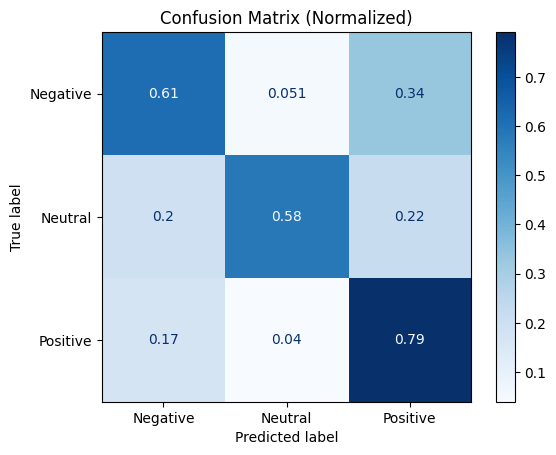

In [94]:
# Normalized confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)
disp_norm = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=["Negative","Neutral","Positive"])
disp_norm.plot(cmap='Blues')
plt.title("Confusion Matrix (Normalized)")
plt.show()

### 5. Result analysis

The Categorical HMM-based sentiment classifier achieved an accuracy of 68.1%. While the model demonstrates strong performance in identifying Positive sentiments (class 1) with a recall of 79% and an F1-score of 0.743, its performance is less consistent for Neutral (class 0) and especially Negative (class -1) cases.
- Positive (class 1): The model performs best on this class, correctly identifying 79% of Positive sentences with relatively low misclassification. Only 17% are confused with Negative and 4% with Neutral.
- Neutral (class 0): About 58% of Neutral samples are correctly classified. However, 22% are misclassified as Positive and 20% as Negative, suggesting the model struggles to distinguish this class cleanly, especially when sentiment expression is subtle or ambiguous.
- Negative (class -1): This class shows the weakest performance. Although 61% are correctly predicted, a significant 34% are misclassified as Positive, and 5% as Neutral. This indicates that the model often fails to separate strongly negative expressions from positive ones.

Macro average F1-score is 0.661, suggesting moderate overall performance across all classes. The weighted average F1-score of 0.684 reflects better performance for majority classes (Positive and Neutral), due to their larger support.

These results suggest the model may benefit from more discriminative features for Negative vs Positive separation and possibly more balanced training or class-specific modeling techniques to enhance recognition of underrepresented or ambiguous classes.

### 6. Conclusion

The Hidden Markov Model (HMM) approach for sentiment classification demonstrates the feasibility of modeling sequential dependencies in text data, leveraging the probabilistic structure of language. This method shows competitive performance, particularly in identifying Positive sentiment, with an overall accuracy of 68.1% and a weighted F1-score of 0.684.

Using the HMM can have several advantages:
- HMM naturally captures the order of words, which is beneficial in sentiment tasks where context and position matter.
- The transition and emission probabilities provide interpretable insights into how sentiment states evolve and relate to observed tokens.
- HMMs are relatively lightweight and efficient to train compared to deep learning models, making them suitable for smaller datasets or faster iterations.

Besides, there are also drawbacks in using this kind of model:
- HMMs assume a Markov property and simple emission distributions, which may not capture the complexity of natural language sentiment.
- Token-based emissions can lead to sparse representations, especially with a large vocabulary, reducing robustness on diverse expressions.
- As seen in the results, the model often misclassifies Neutral and Negative sentiments, suggesting limitations in modeling nuance and ambiguity.

In summary, while HMM offers a principled and interpretable approach to sentiment classification with moderate success, especially in clear-cut cases, it faces challenges in handling nuanced language, indicating the need for more expressive models or richer feature sets for improved performance.